In [ ]:
# Parámetros iniciales
max_tasks = 2500
max_servers = 499
n_iterations = 50
a_decay = (2 - 0.1) / n_iterations

# Cargar datasets ya preprocesados
batch_task = pd.read_csv('/content/batch_task18_cleaned.csv', nrows=max_tasks)
server_usage = pd.read_csv('/content/server_usage18_cleaned.csv', nrows=max_servers)

# Inicialización del algoritmo
n_servers, n_tasks = len(server_usage), len(batch_task)
positions = np.random.uniform(0.2, 0.6, (n_servers, n_tasks)).astype(np.float32)
alpha_pos, beta_pos, delta_pos = np.zeros(n_tasks), np.zeros(n_tasks), np.zeros(n_tasks)
alpha_score, beta_score, delta_score = float('inf'), float('inf'), float('inf')

# Lista para almacenar el mejor fitness por iteración
best_fitness_values = []

# Función de fitness con límites estrictos y ajustes dinámicos
def fitness_function(positions, batch_task):
    total_cpu_usage = np.dot(positions > 0.5, batch_task['plan_cpu'])
    total_memory_usage = np.dot(positions > 0.5, batch_task['plan_mem'])

    # Aplicar penalización por cada tarea que excede el 90% de uso
    penalties = np.sum(total_cpu_usage > 90) + np.sum(total_memory_usage > 90)
    penalty_factor = 10000  # Penalización fuerte para violaciones

    # Ajustar valores de fitness con restricciones estrictas
    return np.sum(total_cpu_usage) + np.sum(total_memory_usage) + penalties * penalty_factor

# Actualizar posiciones con control explícito de restricciones
def update_positions(positions, alpha_pos, beta_pos, delta_pos, a, r1_vals, r2_vals):
    C1, C2, C3 = 2 * r2_vals, 2 * r2_vals, 2 * r2_vals
    A1, A2, A3 = 2 * a * r1_vals - a, 2 * a * r1_vals - a, 2 * a * r1_vals - a

    D_alpha = np.abs(C1 * alpha_pos - positions)
    D_beta = np.abs(C2 * beta_pos - positions)
    D_delta = np.abs(C3 * delta_pos - positions)

    X1 = alpha_pos - A1 * D_alpha
    X2 = beta_pos - A2 * D_beta
    X3 = delta_pos - A3 * D_delta

    updated_positions = (X1 + X2 + X3) / 3
    updated_positions = np.clip(updated_positions, 0.2, 0.6)

    # Validar que no se excedan las restricciones en términos de uso de recursos
    for i in range(updated_positions.shape[0]):
        cpu_usage = np.dot(updated_positions[i] > 0.5, batch_task['plan_cpu'])
        mem_usage = np.dot(updated_positions[i] > 0.5, batch_task['plan_mem'])
        if cpu_usage > 90 or mem_usage > 90:
            updated_positions[i] *= 0.9  # Reducir el impacto de las posiciones conflictivas

    return updated_positions

# Mostrar asignaciones con control explícito de restricciones
def mostrar_asignaciones(position_vector, batch_task, nombre_solucion):
    total_cpu_usage = np.dot(position_vector > 0.5, batch_task['plan_cpu'])
    total_memory_usage = np.dot(position_vector > 0.5, batch_task['plan_mem'])
    penalizaciones = np.sum(total_cpu_usage > 90) + np.sum(total_memory_usage > 90)

    print(f"Solución {nombre_solucion}:")
    print(f"Uso total de CPU: {total_cpu_usage:.2f}")
    print(f"Uso total de Memoria: {total_memory_usage:.2f}")
    print(f"Penalización por violaciones de restricciones: {penalizaciones}")

# Ejecutar el Algoritmo de Optimización del Lobo Gris (GWO)
for iteration in range(n_iterations):
    a = 2 - iteration * a_decay
    fitness = fitness_function(positions, batch_task)

    # Encontrar las mejores posiciones (Alpha, Beta, Delta)
    if fitness < alpha_score:
        delta_score, delta_pos = beta_score, beta_pos.copy()
        beta_score, beta_pos = alpha_score, alpha_pos.copy()
        alpha_score, alpha_pos = fitness, positions[0].copy()
    elif fitness < beta_score:
        delta_score, delta_pos = beta_score, beta_pos.copy()
        beta_score, beta_pos = fitness, positions[0].copy()
    elif fitness < delta_score:
        delta_score, delta_pos = fitness, positions[0].copy()

    # Guardar el mejor fitness
    best_fitness_values.append(alpha_score)

    # Actualizar posiciones
    r1_vals = np.random.rand(n_servers, n_tasks)
    r2_vals = np.random.rand(n_servers, n_tasks)
    positions = update_positions(positions, alpha_pos, beta_pos, delta_pos, a, r1_vals, r2_vals)
    print(f"Iteración {iteration + 1}, Mejor fitness: {alpha_score}")

# Visualizar resultados
print("\n--- Solución Alfa ---")
mostrar_asignaciones(alpha_pos, batch_task, "Alfa")
print("\n--- Solución Beta ---")
mostrar_asignaciones(beta_pos, batch_task, "Beta")
print("\n--- Solución Delta ---")
mostrar_asignaciones(delta_pos, batch_task, "Delta")

Iteración 1, Mejor fitness: 10155675.795765614
Iteración 2, Mejor fitness: 5452393.530990988
Iteración 3, Mejor fitness: 5087539.871534002
Iteración 4, Mejor fitness: 5087539.871534002
Iteración 5, Mejor fitness: 5086597.031476766
Iteración 6, Mejor fitness: 5081973.056610503
Iteración 7, Mejor fitness: 5073193.629864897
Iteración 8, Mejor fitness: 5060179.309707355
Iteración 9, Mejor fitness: 4876069.708902822
Iteración 10, Mejor fitness: 4152054.1393986447
Iteración 11, Mejor fitness: 2979128.537849772
Iteración 12, Mejor fitness: 1305547.7225135032
Iteración 13, Mejor fitness: 231345.0086120093
Iteración 14, Mejor fitness: 78869.01299166305
Iteración 15, Mejor fitness: 55055.306143997295
Iteración 16, Mejor fitness: 52928.32934478363
Iteración 17, Mejor fitness: 52928.32934478363
Iteración 18, Mejor fitness: 52128.784237260064
Iteración 19, Mejor fitness: 52128.784237260064
Iteración 20, Mejor fitness: 52128.784237260064
Iteración 21, Mejor fitness: 52128.784237260064
Iteración 22, 

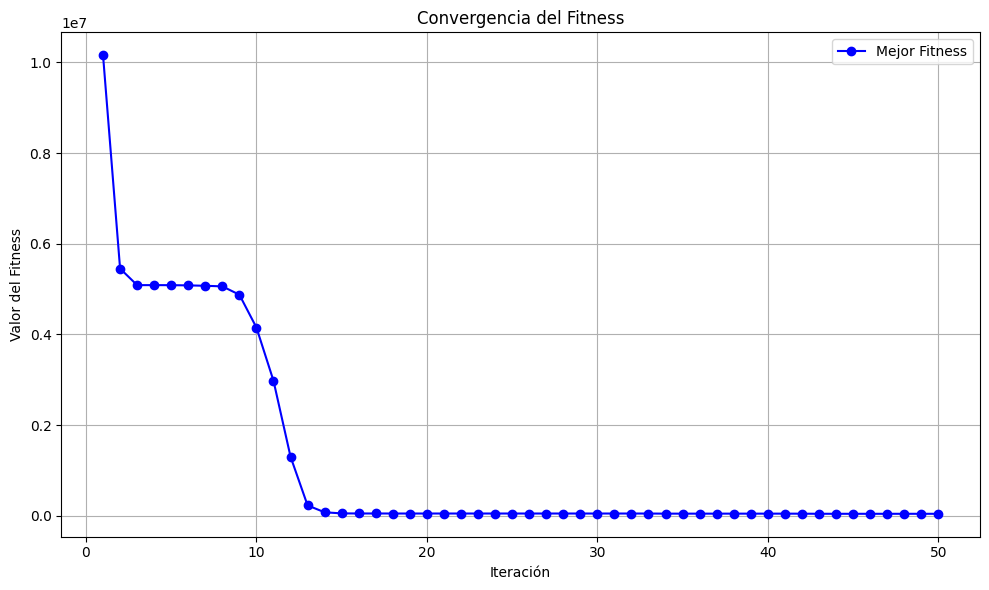

In [ ]:
# Gráfica de convergencia del fitness
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_fitness_values) + 1), best_fitness_values, marker='o', linestyle='-', color='b', label='Mejor Fitness')
plt.title('Convergencia del Fitness')
plt.xlabel('Iteración')
plt.ylabel('Valor del Fitness')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

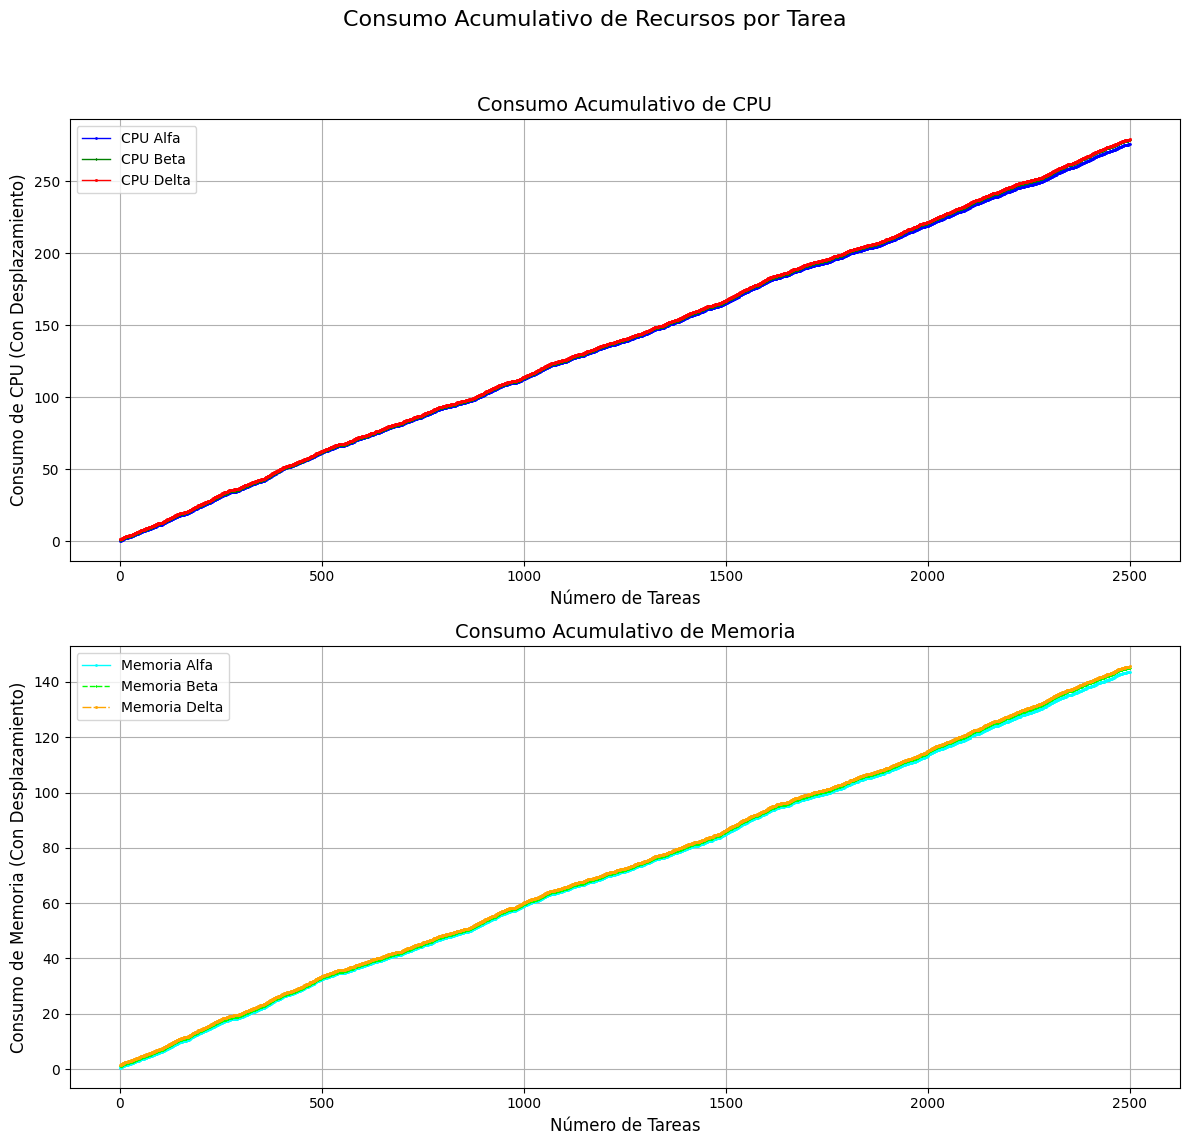

In [ ]:
# Crear dos gráficos separados para CPU y Memoria
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Consumo Acumulativo de Recursos por Tarea', fontsize=16)

# Desplazar levemente las líneas para visualización (sin alterar los valores reales)
cpu_alfa_offset = cpu_alfa + 0.5  # Pequeño desplazamiento
cpu_beta_offset = cpu_beta + 1.0
cpu_delta_offset = cpu_delta + 1.5

memoria_alfa_offset = memoria_alfa + 0.5
memoria_beta_offset = memoria_beta + 1.0
memoria_delta_offset = memoria_delta + 1.5

# Gráfico de Consumo de CPU
axs[0].plot(n_tareas, cpu_alfa_offset, label='CPU Alfa', linestyle='-', color='blue', linewidth=1, marker='o', markersize=1)
axs[0].plot(n_tareas, cpu_beta_offset, label='CPU Beta', linestyle='-', color='green', linewidth=1, marker='x', markersize=1)
axs[0].plot(n_tareas, cpu_delta_offset, label='CPU Delta', linestyle='-', color='red', linewidth=1, marker='s', markersize=1)
axs[0].set_title('Consumo Acumulativo de CPU', fontsize=14)
axs[0].set_xlabel('Número de Tareas', fontsize=12)
axs[0].set_ylabel('Consumo de CPU (Con Desplazamiento)', fontsize=12)
axs[0].legend(fontsize=10)
axs[0].grid(True)

# Gráfico de Consumo de Memoria
axs[1].plot(n_tareas, memoria_alfa_offset, label='Memoria Alfa', linestyle='-', color='cyan', linewidth=1, marker='o', markersize=1)
axs[1].plot(n_tareas, memoria_beta_offset, label='Memoria Beta', linestyle='--', color='lime', linewidth=1, marker='x', markersize=1)
axs[1].plot(n_tareas, memoria_delta_offset, label='Memoria Delta', linestyle='-.', color='orange', linewidth=1, marker='s', markersize=1)
axs[1].set_title('Consumo Acumulativo de Memoria', fontsize=14)
axs[1].set_xlabel('Número de Tareas', fontsize=12)
axs[1].set_ylabel('Consumo de Memoria (Con Desplazamiento)', fontsize=12)
axs[1].legend(fontsize=10)
axs[1].grid(True)

# Ajustar el espacio entre los gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


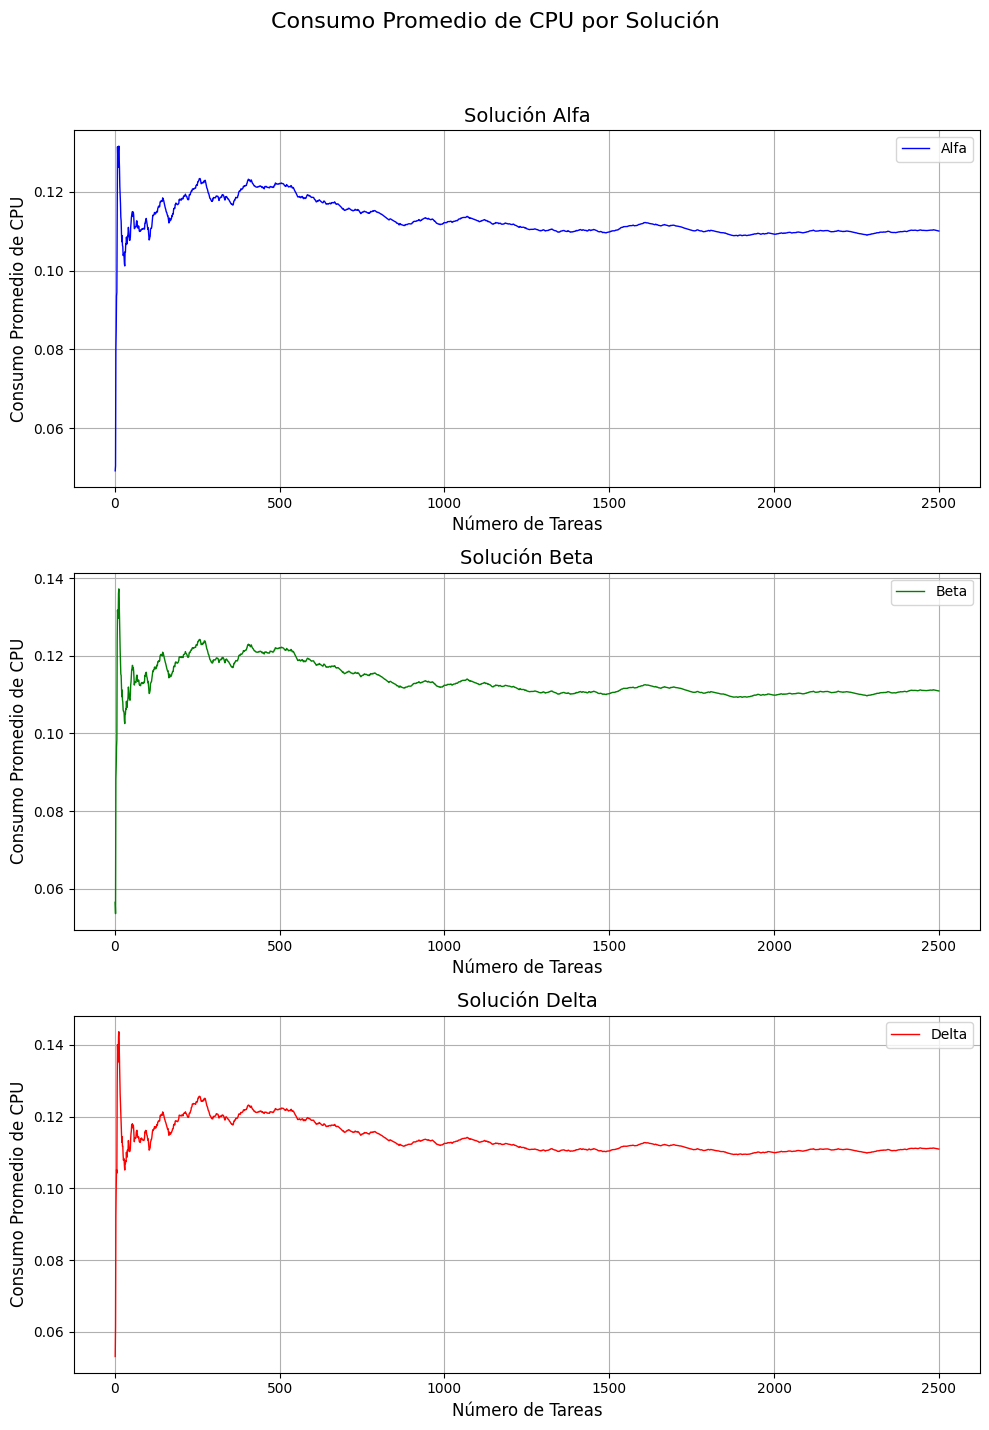

In [ ]:
# Calcular el consumo promedio de CPU para cada tarea
cpu_alfa_promedio = cpu_alfa / np.arange(1, n_tasks + 1)
cpu_beta_promedio = cpu_beta / np.arange(1, n_tasks + 1)
cpu_delta_promedio = cpu_delta / np.arange(1, n_tasks + 1)

# Crear subplots para las 3 gráficas de consumo de CPU promedio
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Consumo Promedio de CPU por Solución', fontsize=16)

# Gráfica para la solución Alfa
axs[0].plot(range(1, n_tasks + 1), cpu_alfa_promedio, label='Alfa', color='blue', linestyle='-', linewidth=1)
axs[0].set_title('Solución Alfa', fontsize=14)
axs[0].set_xlabel('Número de Tareas', fontsize=12)
axs[0].set_ylabel('Consumo Promedio de CPU', fontsize=12)
axs[0].legend()
axs[0].grid(True)

# Gráfica para la solución Beta
axs[1].plot(range(1, n_tasks + 1), cpu_beta_promedio, label='Beta', color='green', linestyle='-', linewidth=1)
axs[1].set_title('Solución Beta', fontsize=14)
axs[1].set_xlabel('Número de Tareas', fontsize=12)
axs[1].set_ylabel('Consumo Promedio de CPU', fontsize=12)
axs[1].legend()
axs[1].grid(True)

# Gráfica para la solución Delta
axs[2].plot(range(1, n_tasks + 1), cpu_delta_promedio, label='Delta', color='red', linestyle='-', linewidth=1)
axs[2].set_title('Solución Delta', fontsize=14)
axs[2].set_xlabel('Número de Tareas', fontsize=12)
axs[2].set_ylabel('Consumo Promedio de CPU', fontsize=12)
axs[2].legend()
axs[2].grid(True)

# Ajustar el espacio entre las gráficas
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


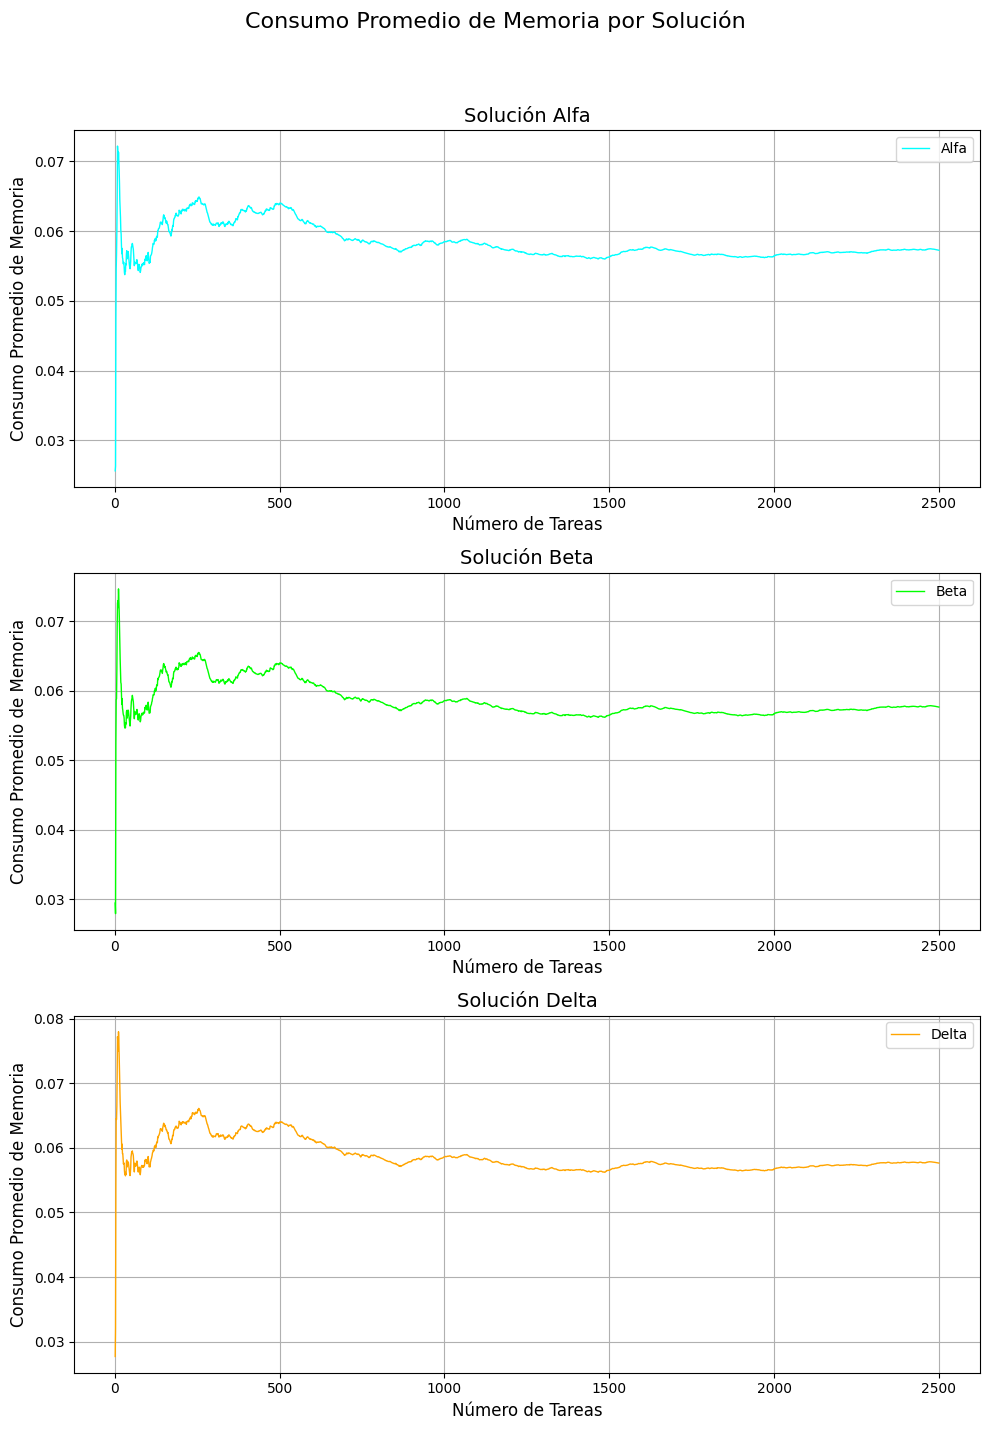

In [ ]:
# Calcular el consumo promedio de Memoria para cada tarea
memoria_alfa_promedio = memoria_alfa / np.arange(1, n_tasks + 1)
memoria_beta_promedio = memoria_beta / np.arange(1, n_tasks + 1)
memoria_delta_promedio = memoria_delta / np.arange(1, n_tasks + 1)

# Crear subplots para las 3 gráficas de consumo de Memoria promedio
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Consumo Promedio de Memoria por Solución', fontsize=16)

# Gráfica para la solución Alfa
axs[0].plot(range(1, n_tasks + 1), memoria_alfa_promedio, label='Alfa', color='cyan', linestyle='-', linewidth=1)
axs[0].set_title('Solución Alfa', fontsize=14)
axs[0].set_xlabel('Número de Tareas', fontsize=12)
axs[0].set_ylabel('Consumo Promedio de Memoria', fontsize=12)
axs[0].legend()
axs[0].grid(True)

# Gráfica para la solución Beta
axs[1].plot(range(1, n_tasks + 1), memoria_beta_promedio, label='Beta', color='lime', linestyle='-', linewidth=1)
axs[1].set_title('Solución Beta', fontsize=14)
axs[1].set_xlabel('Número de Tareas', fontsize=12)
axs[1].set_ylabel('Consumo Promedio de Memoria', fontsize=12)
axs[1].legend()
axs[1].grid(True)

# Gráfica para la solución Delta
axs[2].plot(range(1, n_tasks + 1), memoria_delta_promedio, label='Delta', color='orange', linestyle='-', linewidth=1)
axs[2].set_title('Solución Delta', fontsize=14)
axs[2].set_xlabel('Número de Tareas', fontsize=12)
axs[2].set_ylabel('Consumo Promedio de Memoria', fontsize=12)
axs[2].legend()
axs[2].grid(True)

# Ajustar el espacio entre las gráficas
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


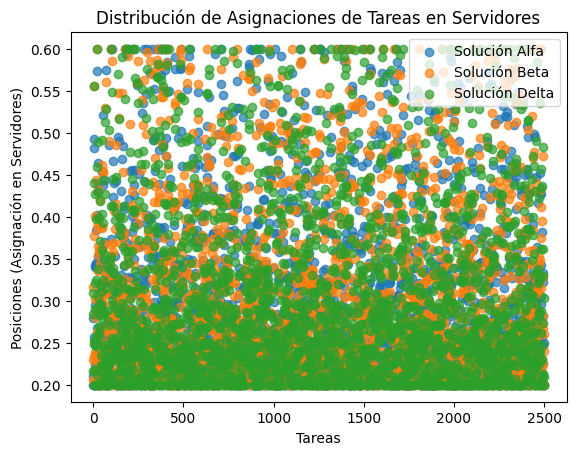

In [ ]:
# Generando datos ejemplo para visualización.
plt.scatter(range(n_tasks), alpha_pos, label="Solución Alfa", alpha=0.7)
plt.scatter(range(n_tasks), beta_pos, label="Solución Beta", alpha=0.7)
plt.scatter(range(n_tasks), delta_pos, label="Solución Delta", alpha=0.7)
plt.xlabel("Tareas")
plt.ylabel("Posiciones (Asignación en Servidores)")
plt.title("Distribución de Asignaciones de Tareas en Servidores")
plt.legend()
plt.show()
